In [1]:
import utilities.load_image as loader
import construct_kernel.layers as nn
import kr_solvers.expander as expander
import kr_solvers.exact_solve as exact_solve
import kr_solvers.eigenpro_solve as eigenpro_solve
import mpld3
mpld3.enable_notebook()

# Construct a network for which we will compute the CNTK 
net = nn.Sequential(nn.Conv(kernel_size=3),
                    nn.LeakyReLU(),
                    nn.Downsample(),
                    nn.Conv(kernel_size=3),
                    nn.LeakyReLU(),                    
                    nn.Downsample(),
                    nn.Conv(kernel_size=3),
                    nn.LeakyReLU(),
                    nn.Downsample(),      
                    nn.Conv(kernel_size=3),
                    nn.LeakyReLU(),
                    nn.Upsample(bilinear=False),                    
                    nn.Conv(kernel_size=3),
                    nn.LeakyReLU(),
                    nn.Upsample(bilinear=False),
                    nn.Conv(kernel_size=3),
                    nn.LeakyReLU(),
                    nn.Upsample(bilinear=False),
                    nn.Conv(kernel_size=3))


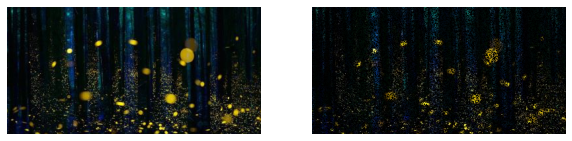

In [16]:
fname = 'data/3.jpg'
clean, corrupted, mask = loader.load_image(fname)
loader.visualize_corrupted_image(clean, corrupted)

In [3]:
# Provide an image size, number of CPU threads, and possibly a feature prior X for computing the kernel 
image_size = 16
K = net.get_ntk(image_size, num_threads=10)
print(K.shape)

100%|██████████| 19/19 [00:19<00:00,  1.00s/it]

(16, 16, 16, 16)


Loaded Kernel; Now Subsetting Observed Entries
Starting exact solve for kernel regression
This system has 36982 equations & unknowns.
340.658810377121  time for solve


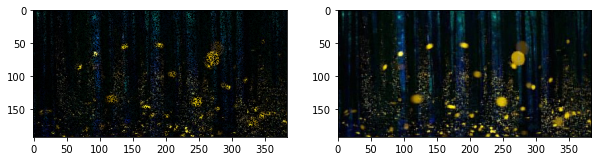

In [17]:
import utilities.visualizer as vis

s = 3  # Number of downsampling / upsampling layers in network
_, w, h = corrupted.shape  # Shape to expand our kernel to (we only need width and height)
K_expanded = expander.expand_kernel(K, s, w, h)
imputed_img_exact = exact_solve.kr_solve(K_expanded, corrupted, mask)
vis.visualize_images(corrupted, imputed_img_exact)

(36982, 2) (36982, 3)
Training Model
SVD time: 2.80, top_q: 53, top_eigval: 0.26, new top_eigval: 4.68e-04
n_subsamples=2000, bs_gpu=2000, eta=2001.02, bs=2000, top_eigval=2.57e-01, beta=1.00
train error: 0.02260	 (0 epochs, 0.00 seconds)
train error: 0.00135	 (10 epochs, 33.25 seconds)
train error: 0.00079	 (20 epochs, 69.06 seconds)


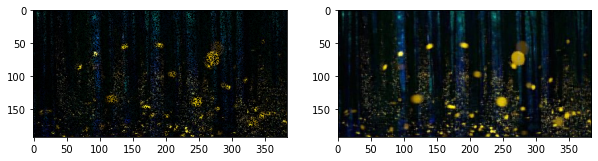

In [18]:
s = 3  # Number of downsampling / upsampling layers in network
imputed_img = eigenpro_solve.expand_and_solve(K, corrupted, mask, s, max_iter=20)
vis.visualize_images(corrupted, imputed_img)


e:\GraduateCourses\MatrixAnalysis\Homeworks\project\refs\ntk_matrix_completion-main\image_inpainting_notebooks\utilities\visualizer.py:19: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


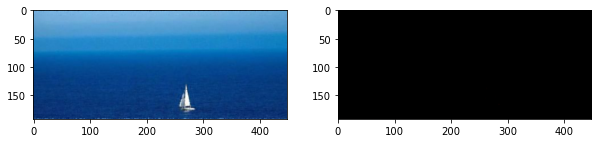

In [8]:
noise = corrupted - imputed_img
vis.visualize_images(imputed_img, noise)

In [19]:
import numpy as np
i = 2
np.save(f'data/clean_{i}', clean)
np.save(f'data/corrupted_{i}', corrupted)
np.save(f'data/imputed_img_exact_{i}', imputed_img_exact)
np.save(f'data/imputed_img_{i}', imputed_img)
